In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
#print(os.listdir("../input"))

In [3]:
#Load sub data
#mol_dataset= pd.read_csv("../input/prepare-dataset-rdkit-rev-2/mol_dataset.csv")
mol_dataset= pd.read_csv("mol_dataset.csv")
mol_dataset.head(5)

,molecule_name,mol_data,smiles,0,1,2,3,4,5,6,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1c60>,C,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1da0>,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x7f2e52743f80>,O,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1e90>,C#N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dsgdb9nsd_000007,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1f30>,CC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#reduce data size
mol_dataset = reduce_mem_usage(mol_dataset)

Mem. usage decreased to 60.74 Mb (83.5% reduction)


In [5]:
#cut string data
mol_dataset = mol_dataset.drop(['mol_data' , 'smiles'], axis=1)
mol_dataset.head(5)

#mol_fingerprint = mol_dataset.iloc[:,3:170]
#mol_fingerptint.shape

#mol_descriptor = mol_dataset.iloc[:,171:370]
#mol_descriptor.shape

,molecule_name,0,1,2,3,4,5,6,7,8,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,dsgdb9nsd_000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dsgdb9nsd_000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,dsgdb9nsd_000003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,dsgdb9nsd_000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dsgdb9nsd_000007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mol_name = mol_dataset["molecule_name"]
mol_dataset = mol_dataset.iloc[:,1:368]
#mol_high_std

There are a lot of 0 or 1 data, and no variance columns.  
In addition, low std columns means that there are high bias of data. If this bias is too high, sometime set up bad effect when do CV. If we do 5-fold CV, we sould remove the columns which contain over 80% same data such as 0, 1.

reference:  
https://datachemeng.com/deletedescriptors/  
https://datachemeng.com/wp-content/uploads/2017/09/basicdatapreprocessing.pdf

According to result of LightGBM_using_new_features_rev.0, many of parameters don't have strong impact for model.  
So in rev.1 we try to use only top 20 of fingerprints and descriptors. (Rough parameter selection)

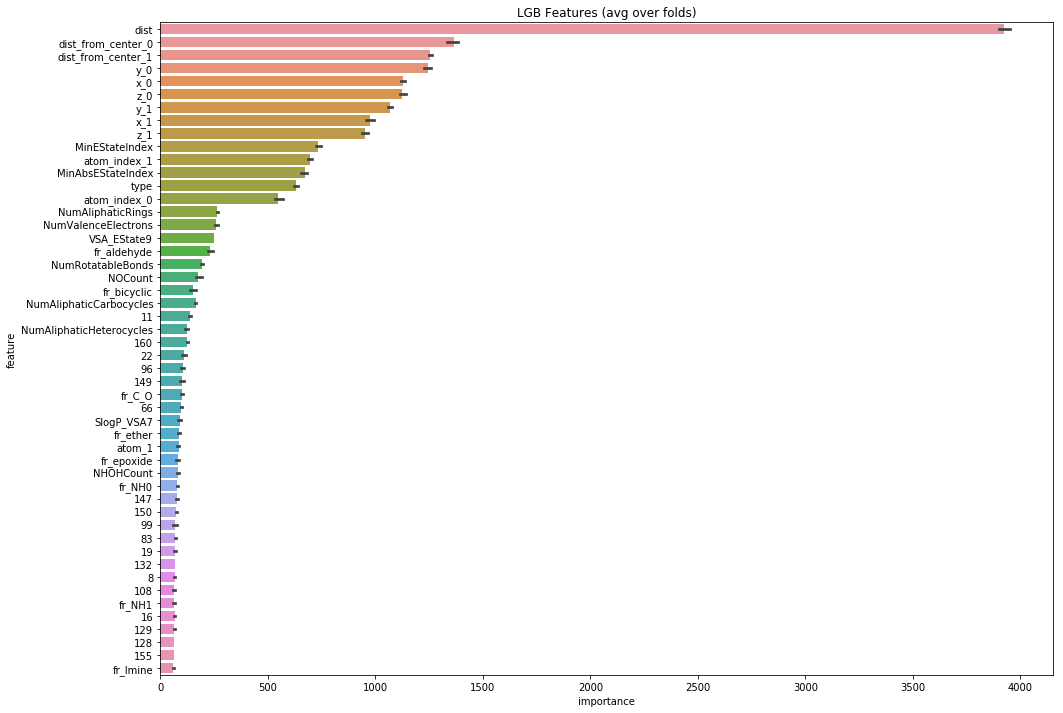

![](http://)

In [7]:
#blocking
#drop_mol =mol_high_std.drop(["102", "107","134","112", "117","119","122", "148","124","130", "143","162", "76",
#                 "NumAromaticHeterocycles","NumAromaticRings","NumHAcceptors","NumHeteroatoms", "NumHDonors",
#                 "NumSaturatedCarbocycles","NumSaturatedHeterocycles", "NumSaturatedRings","RingCount","
#                 "fr_C_O_noCOO","fr_NH2", "fr_Nhpyrrole","fr_nitrile", 
#                 "fr_oxime"] , axis=1)

#fr_COO", "fr_COO2","NumAromaticCarbocycles","fr_nitro","fr_nitro_arom_nonortho",, "fr_phenol_noOrthoHbond"

In [8]:
#omit high bias varibles
#drop_mol=drop_mol.drop(["166","15","125","21","23","24","25","26","28","42","45","49","56","63","87",
#                        "fr_Al_OH","fr_Ar_COO","fr_HOCCN","fr_alkyl_carbamate","fr_alkyl_halide",
#                        "fr_azo","fr_diazo","fr_dihydropyridine","fr_furan","fr_guanido","fr_hdrzone","fr_imidazole",
#                        "fr_imide","fr_lactam","fr_morpholine","fr_nitro_arom","fr_nitroso","fr_oxazole","fr_para_hydroxylation",
#                        "fr_phenol","fr_piperzine","fr_pyridine","fr_quatN","fr_tetrazole","fr_unbrch_alkane","fr_urea"], 
#                       axis=1)

In [9]:
#Choose top 20 parameters
drop_mol=mol_dataset.loc[:, ["MinEStateIndex",
                     "MinAbsEStateIndex",
                     "NumAliphaticRings",
                     "NumValenceElectrons",
                     "VSA_EState9",
                     "fr_aldehyde",
                     "NumRotatableBonds",
                     "NOCount",
                     "fr_bicyclic",
                     "NumAliphaticCarbocycles",
                     "11",
                     "NumAliphaticHeterocycles",
                     "160",
                     "22",
                     "96",
                     "149",
                     "fr_C_O",
                     "66",
                     "SlogP_VSA7",
                     "fr_ether"]]

In [10]:
drop_mol.head()

,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,0.0,0.0,0,8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0
1,0.0,0.0,0,8,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
2,0.0,0.0,0,8,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
3,3.5,3.5,0,10,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
4,2.0,2.0,0,14,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,0


OK, now 367 comlums become only 135 columns after rough pre-processing.

In [11]:
#marge
drop_mol["molecule_name"]=mol_name
drop_mol.head(5)

,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,...,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether,molecule_name
0,0.0,0.0,0,8,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.0,0,dsgdb9nsd_000001
1,0.0,0.0,0,8,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000002
2,0.0,0.0,0,8,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000003
3,3.5,3.5,0,10,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000005
4,2.0,2.0,0,14,0.0,0,0,0,0,0,...,0,1,0,0,1,0,0,0.0,0,dsgdb9nsd_000007


In [12]:
#devide dataset
train_mol = drop_mol[0:85003]
test_mol = drop_mol[85003:130776]
test_mol.head(5)

,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,...,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether,molecule_name
85003,4.000000,4.000000,0,10,0.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000004
85004,1.625000,1.625000,0,20,3.25,0,0,1,0,0,...,0,1,0,0,1,0,0,0.0,1,dsgdb9nsd_000015
85005,1.500000,1.500000,1,18,0.00,0,0,0,0,1,...,0,0,1,0,0,0,0,0.0,0,dsgdb9nsd_000016
85006,-0.833496,0.833496,0,24,0.00,0,0,3,0,0,...,0,0,0,0,0,1,0,0.0,0,dsgdb9nsd_000020
85007,-0.166626,0.166626,0,26,0.00,0,0,1,0,0,...,0,1,0,0,1,0,0,0.0,0,dsgdb9nsd_000022


In [13]:
#prepare dataset for modeling
#Load data
#train = pd.read_csv("../input/champs-scalar-coupling/train.csv")
#test = pd.read_csv("../input/champs-scalar-coupling/test.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Load sub data
#sub = pd.read_csv("../input/champs-scalar-coupling/sample_submission.csv")
#structures = pd.read_csv("../input/champs-scalar-coupling/structures.csv")
sub = pd.read_csv("sample_submission.csv")
structures = pd.read_csv("structures.csv")

In [14]:
#def map_atom_info(df, atom_idx):
#    df = pd.merge(df, structures, how = 'left',
#                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
#                  right_on = ['molecule_name',  'atom_index'])
    
#    df = df.drop('atom_index', axis=1)
#    df = df.rename(columns={'atom': f'atom_{atom_idx}',
#                            'x': f'x_{atom_idx}',
#                            'y': f'y_{atom_idx}',
#                            'z': f'z_{atom_idx}'})
    #structures['c_x'] = structures.groupby('molecule_name')['x'].transform('mean')
    #structures['c_y'] = structures.groupby('molecule_name')['y'].transform('mean')
    #structures['c_z'] = structures.groupby('molecule_name')['z'].transform('mean')
#    return df

In [15]:
#train_structure = map_atom_info(train, 0)
#train_structure = map_atom_info(train_structure, 1)
#test_structure = map_atom_info(test, 0)
#test_structure = map_atom_info(test_structure, 1)

#train_structure.head(5)

In [16]:
def map_atom_info(df_1, df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    return df

def get_features(df, struct):
    for atom_idx in [0,1]:
        df = map_atom_info(df, struct, atom_idx)
        df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
        struct['c_x'] = struct.groupby('molecule_name')['x'].transform('mean')
        struct['c_y'] = struct.groupby('molecule_name')['y'].transform('mean')
        struct['c_z'] = struct.groupby('molecule_name')['z'].transform('mean')

   # df = find_dist(df)
   # df = find_closest_atom(df)
   # df = add_cos_features(df)
   # df = add_dist_features(df)
   # df = add_qm9_features(df)
    
    return df

In [17]:
train_structure = get_features(train, structures.copy())
test_structure = get_features(test, structures.copy())

train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,-0.012689,1.085797,0.008001
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,-0.012689,1.085797,0.008001
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,-0.012689,1.085797,0.008001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001


In [18]:
train_p_0 = train_structure[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_structure[['x_1', 'y_1', 'z_1']].values
train_structure['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
train_structure['dist_x'] = (train_structure['x_0'] - train_structure['x_1']) ** 2
train_structure['dist_y'] = (train_structure['y_0'] - train_structure['y_1']) ** 2
train_structure['dist_z'] = (train_structure['z_0'] - train_structure['z_1']) ** 2
train_structure['dist_from_center_0'] = np.linalg.norm(train_p_0, axis=1)
train_structure['dist_from_center_1'] = np.linalg.norm(train_p_1, axis=1)

test_p_0 = test_structure[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_structure[['x_1', 'y_1', 'z_1']].values
test_structure['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
test_structure['dist_x'] = (test_structure['x_0'] - test_structure['x_1']) ** 2
test_structure['dist_y'] = (test_structure['y_0'] - test_structure['y_1']) ** 2
test_structure['dist_z'] = (test_structure['z_0'] - test_structure['z_1']) ** 2
test_structure['dist_from_center_0'] = np.linalg.norm(test_p_0, axis=1)
test_structure['dist_from_center_1'] = np.linalg.norm(test_p_1, axis=1)

In [19]:
train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,...,0.008001,-0.012689,1.085797,0.008001,1.091953,0.000220,1.192105,0.000036,0.006701,1.085908
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,...,0.000277,-0.012689,1.085797,0.008001,1.783120,1.019253,2.160261,0.000003,0.006701,1.779373
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,...,-0.876644,-0.012689,1.085797,0.008001,1.783147,0.294812,2.112831,0.771973,0.006701,1.776603
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,...,0.906397,-0.012689,1.085797,0.008001,1.783157,0.276638,2.085032,0.817978,0.006701,1.778648
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,...,0.008001,-0.012689,1.085797,0.008001,1.091952,1.049455,0.142844,0.000060,1.779373,1.085908


#Add more featutes using by Feature generation funcs  
Reference:https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28  

First the type is encoded by a label encoder.  
The merging template and selected features from Andrew's brute force feature engineering  
Cosine features originally from Effective feature and expanded in Keras Neural Net for CHAMPS, I simplified the generation procedure by  removing unnecessary pandas operations since vanilla numpy arrays operation is faster.  
QM9 dataset from Quantum Machine 9 - QM9.  
Parallelization computed Yukawa potentials.  
Giba's features from Giba R + data.table + Simple Features, which I now export the features to a dataset: Giba molecular features.  

In [20]:
def find_closest_atom(df):    
    df_temp = df.loc[:,["molecule_name",
                      "atom_index_0","atom_index_1",
                      "dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_ = df_temp.copy()
    df_temp_ = df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all = pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('max')
    
    df_temp = df_temp_all[df_temp_all["min_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp = df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'dist': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'dist': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df

In [21]:
train_structure = find_closest_atom(train_structure)
test_structure = find_closest_atom(test_structure)

train_structure.head(5)

/Users/hasegawatooru/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,...,-0.523814,1.437933,0.906397,1.091953,1,1.091953,0.002150,-0.006031,0.001976,1.091946
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,...,-0.523814,1.437933,0.906397,1.091953,3,1.783158,-0.540815,1.447527,-0.876644,1.091952
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,...,-0.523814,1.437933,0.906397,1.091953,2,1.783158,1.011731,1.463751,0.000277,1.091946
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,...,-0.523814,1.437933,0.906397,1.091953,1,1.783157,0.002150,-0.006031,0.001976,1.091948
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,...,-0.540815,1.447527,-0.876644,1.091952,1,1.091953,0.002150,-0.006031,0.001976,1.091946


In [22]:
def add_cos_features(df):
    
    df["distance_center0"] = np.sqrt((df['x_0']-df['c_x'])**2 \
                                   + (df['y_0']-df['c_y'])**2 \
                                   + (df['z_0']-df['c_z'])**2)
    df["distance_center1"] = np.sqrt((df['x_1']-df['c_x'])**2 \
                                   + (df['y_1']-df['c_y'])**2 \
                                   + (df['z_1']-df['c_z'])**2)
    
    df['distance_c0'] = np.sqrt((df['x_0']-df['x_closest_0'])**2 + \
                                (df['y_0']-df['y_closest_0'])**2 + \
                                (df['z_0']-df['z_closest_0'])**2)
    df['distance_c1'] = np.sqrt((df['x_1']-df['x_closest_1'])**2 + \
                                (df['y_1']-df['y_closest_1'])**2 + \
                                (df['z_1']-df['z_closest_1'])**2)
    
    df["distance_f0"] = np.sqrt((df['x_0']-df['x_farthest_0'])**2 + \
                                (df['y_0']-df['y_farthest_0'])**2 + \
                                (df['z_0']-df['z_farthest_0'])**2)
    df["distance_f1"] = np.sqrt((df['x_1']-df['x_farthest_1'])**2 + \
                                (df['y_1']-df['y_farthest_1'])**2 + \
                                (df['z_1']-df['z_farthest_1'])**2)
    
    vec_center0_x = (df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    vec_center0_y = (df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    vec_center0_z = (df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    
    vec_center1_x = (df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    vec_center1_y = (df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    vec_center1_z = (df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    
    vec_c0_x = (df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    vec_c0_y = (df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    vec_c0_z = (df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    
    vec_c1_x = (df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    vec_c1_y = (df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    vec_c1_z = (df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    
    vec_f0_x = (df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    vec_f0_y = (df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    vec_f0_z = (df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    
    vec_f1_x = (df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    vec_f1_y = (df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    vec_f1_z = (df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    
    vec_x = (df['x_1']-df['x_0'])/df['dist']
    vec_y = (df['y_1']-df['y_0'])/df['dist']
    vec_z = (df['z_1']-df['z_0'])/df['dist']
    
    df["cos_c0_c1"] = vec_c0_x*vec_c1_x + vec_c0_y*vec_c1_y + vec_c0_z*vec_c1_z
    df["cos_f0_f1"] = vec_f0_x*vec_f1_x + vec_f0_y*vec_f1_y + vec_f0_z*vec_f1_z
    
    df["cos_c0_f0"] = vec_c0_x*vec_f0_x + vec_c0_y*vec_f0_y + vec_c0_z*vec_f0_z
    df["cos_c1_f1"] = vec_c1_x*vec_f1_x + vec_c1_y*vec_f1_y + vec_c1_z*vec_f1_z
    
    df["cos_center0_center1"] = vec_center0_x*vec_center1_x \
                              + vec_center0_y*vec_center1_y \
                              + vec_center0_z*vec_center1_z
    
    df["cos_c0"] = vec_c0_x*vec_x + vec_c0_y*vec_y + vec_c0_z*vec_z
    df["cos_c1"] = vec_c1_x*vec_x + vec_c1_y*vec_y + vec_c1_z*vec_z
    
    df["cos_f0"] = vec_f0_x*vec_x + vec_f0_y*vec_y + vec_f0_z*vec_z
    df["cos_f1"] = vec_f1_x*vec_x + vec_f1_y*vec_y + vec_f1_z*vec_z
    
    df["cos_center0"] = vec_center0_x*vec_x + vec_center0_y*vec_y + vec_center0_z*vec_z
    df["cos_center1"] = vec_center1_x*vec_x + vec_center1_y*vec_y + vec_center1_z*vec_z

    return df

In [23]:
train_structure = add_cos_features(train_structure)
test_structure = add_cos_features(test_structure)

train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,cos_f0_f1,cos_c0_f0,cos_c1_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,...,-0.816502,0.816502,-0.333335,-0.649313,-1.000000,-0.333335,-0.816502,1.000000,-1.000000,0.649319
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,...,0.000016,0.816502,0.816503,-0.333304,-0.816483,0.816482,-0.499994,0.499995,-0.816487,0.816488
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,...,-0.000016,0.816502,0.816501,-0.333335,-0.816498,0.816496,-0.500002,0.500018,-0.816496,0.816499
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,...,-1.000000,0.816502,0.816500,-0.333349,-0.816502,0.816500,-1.000000,1.000000,-0.816500,0.816503
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,...,-0.000028,0.816503,-0.333335,-0.499068,-1.000000,-0.333352,-0.816503,-0.333287,-1.000000,0.499076


In [24]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    #for cat_col in tqdm_notebook(cat_cols):
    #    for num_col in num_cols:
   #         for agg in aggs:
   #             df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
    #            df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
    #            df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]

    df = reduce_mem_usage(df)
    return df

In [25]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

In [26]:
train_structure['type_0'] = train_structure['type'].apply(lambda x: x[0])
test_structure['type_0'] = test_structure['type'].apply(lambda x: x[0])

train_structure = create_features_full(train_structure)
test_structure = create_features_full(test_structure)
train_structure = create_features(train_structure)
test_structure = create_features(test_structure)

Mem. usage decreased to 826.28 Mb (70.2% reduction)
Mem. usage decreased to 439.66 Mb (70.1% reduction)
Mem. usage decreased to 1270.51 Mb (4.7% reduction)
Mem. usage decreased to 678.61 Mb (4.7% reduction)


In [27]:
train_structure = train_structure.drop('type_0', axis=1)
test_structure = test_structure.drop('type_0', axis=1)

In [28]:
#merge data
train_merged = pd.merge(train_structure, train_mol, how="inner", on ="molecule_name")
#train_merged.head(5)
test_merged = pd.merge(test_structure, test_mol, how="inner", on ="molecule_name")
test_merged.head(5)


,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,...,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662109,0.0,1.0,C,...,0,0,0,0,0,0,0,0,0.0,0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662109,0.0,1.0,C,...,0,0,0,0,0,0,0,0,0.0,0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662109,0.0,1.0,H,...,0,0,0,0,0,0,0,0,0.0,0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662109,0.0,1.0,C,...,0,0,0,0,0,0,0,0,0.0,0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662109,0.0,1.0,C,...,0,0,0,0,0,0,0,0,0.0,0


In [29]:
test_merged.shape

(2505542, 142)

In [30]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import time
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import gc
import warnings
warnings.filterwarnings("ignore")

/Users/hasegawatooru/anaconda3/envs/kaggle/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [31]:
#Prepare dataset
# Label Encoding
for f in ['atom_0', 'atom_1']:#,'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train_merged[f].values) + list(test_merged[f].values))
    train_merged[f] = lbl.transform(list(train_merged[f].values))
    test_merged[f] = lbl.transform(list(test_merged[f].values))

#If folloing code add above for-loop "lbl.inverse_transform([1])[0]" will fail to re-labeling
lbl = LabelEncoder()
lbl.fit(list(train_merged['type'].values) + list(test_merged['type'].values))
train_merged['type'] = lbl.transform(list(train_merged['type'].values))
test_merged['type'] = lbl.transform(list(test_merged['type'].values))

In [32]:
test_merged.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,...,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,4658147,dsgdb9nsd_000004,2,0,2,0,-1.662109375,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0.0,0
1,4658148,dsgdb9nsd_000004,2,1,0,0,-1.662109375,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0.0,0
2,4658149,dsgdb9nsd_000004,2,3,6,0,-1.662109375,0.0,1.0,1,...,0,0,0,0,0,0,0,0,0.0,0
3,4658150,dsgdb9nsd_000004,3,0,0,0,1.662109375,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0.0,0
4,4658151,dsgdb9nsd_000004,3,1,2,0,1.662109375,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0.0,0


In [33]:
train_merged = reduce_mem_usage(train_merged)
test_merged = reduce_mem_usage(test_merged)

Mem. usage decreased to 1248.30 Mb (7.0% reduction)
Mem. usage decreased to 666.66 Mb (7.0% reduction)


In [34]:
def del_cols(df, cols):
    del_cols_list_ = [l for l in cols if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

y_train = train_merged.scalar_coupling_constant
x_train = del_cols(train_merged, ["molecule_name", "scalar_coupling_constant", "id"])
x_test = del_cols(test_merged, ["molecule_name", "id"])
x_train.head(5)

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,...,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,1,0,0,0,0.00214958190918,-0.006031036376953,0.001976013183594,0,-0.01269531250,1.0859375000,...,0,0,1,0,0,0,0,0,0.0,0
1,1,2,3,0,0.00214958190918,-0.006031036376953,0.001976013183594,1,1.01171875000,1.4638671875,...,0,0,1,0,0,0,0,0,0.0,0
2,1,3,3,0,0.00214958190918,-0.006031036376953,0.001976013183594,1,-0.54101562500,1.4472656250,...,0,0,1,0,0,0,0,0,0.0,0
3,1,4,3,0,0.00214958190918,-0.006031036376953,0.001976013183594,1,-0.52392578125,1.4375000000,...,0,0,1,0,0,0,0,0,0.0,0
4,2,0,0,0,1.01171875000000,1.463867187500000,0.000276565551758,0,-0.01269531250,1.0859375000,...,0,0,1,0,0,0,0,0,0.0,0


In [35]:
#test_merged['type'].unique()
#lbl.inverse_transform([1])[0]

#Build model and Run

In [36]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [37]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [38]:
#Set hyper parameters
params = {'num_leaves': 200,
          #'min_child_samples': 32,
          'objective': 'regression',  #I will check it.
          'max_depth': 9,
          'learning_rate': 0.08,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.8,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          #'reg_alpha': 0.8,
          #'reg_lambda': 0.2,
          #'colsample_bytree': 0.6
          'lambda_l1': 0.8,
          'lambda_l2': 0.2,
          'feature_fraction': 0.6,
         }

#Training by type with time seed  
Type 0 = 1JHC. 
Type 1 = 1JHN. 
Type 2 = 2JHC. 
Type 3 = 2JHH. 
Type 4 = 2JHN. 
Type 5 = 3JHC. 
Type 6 = 3JHH. 
Type 7 = 3JHN. 

Reference:  
https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28

In [39]:
n_fold = 4
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [40]:
#We use different numbers of iterations for different type, after running the label encoder
###Iters###    [1JHC, 1JHN, 2JHC, 2JHH, 2JHN, 3JHC, 3JHH, 3JHN]
n_estimators = [10000, 4000, 4000, 2500, 2500, 4000, 2500, 2500]

In [41]:
#test_merged['type'].unique()
#train_structure['atom_1'].describe()

In [42]:
X_short = pd.DataFrame({'ind': list(train_merged.index), 
                        'type': train_merged['type'].values,
                        'oof': [0] * len(train_merged), 
                        'target': y_train.values})
X_short_test = pd.DataFrame({'ind': list(test_merged.index), 
                             'type': test_merged['type'].values, 
                             'prediction': [0] * len(test_merged)})

In [43]:
#lbl.inverse_transform([7])[0]


Training of type 0: 1JHC.
Fold 1 started at Sun Jul 28 22:53:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.34448	valid_1's l1: 1.57094
[1000]	training's l1: 1.06381	valid_1's l1: 1.42588
[1500]	training's l1: 0.891235	valid_1's l1: 1.36002
[2000]	training's l1: 0.762739	valid_1's l1: 1.31721
[2500]	training's l1: 0.663675	valid_1's l1: 1.29029
[3000]	training's l1: 0.582569	valid_1's l1: 1.26987
[3500]	training's l1: 0.514852	valid_1's l1: 1.25479
[4000]	training's l1: 0.457898	valid_1's l1: 1.24315
[4500]	training's l1: 0.409042	valid_1's l1: 1.2342
[5000]	training's l1: 0.366554	valid_1's l1: 1.22687
[5500]	training's l1: 0.329639	valid_1's l1: 1.22109
[6000]	training's l1: 0.296985	valid_1's l1: 1.21607
[6500]	training's l1: 0.268523	valid_1's l1: 1.21198
[7000]	training's l1: 0.243424	valid_1's l1: 1.20885
[7500]	training's l1: 0.221068	valid_1's l1: 1.20599
[8000]	training's l1: 0.201099	valid_1's l1: 1.20358
[8500]	training's l1: 0

[4000]	training's l1: 0.012086	valid_1's l1: 0.681144
Did not meet early stopping. Best iteration is:
[4000]	training's l1: 0.012086	valid_1's l1: 0.681144
Fold 3 started at Mon Jul 29 01:55:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.225919	valid_1's l1: 0.705074
[1000]	training's l1: 0.0785362	valid_1's l1: 0.682223
[1500]	training's l1: 0.0360935	valid_1's l1: 0.678156
[2000]	training's l1: 0.0226849	valid_1's l1: 0.676981
[2500]	training's l1: 0.0174499	valid_1's l1: 0.676499
[3000]	training's l1: 0.0147676	valid_1's l1: 0.676268
[3500]	training's l1: 0.013144	valid_1's l1: 0.676134
[4000]	training's l1: 0.0120218	valid_1's l1: 0.676021
Did not meet early stopping. Best iteration is:
[4000]	training's l1: 0.0120218	valid_1's l1: 0.676021
Fold 4 started at Mon Jul 29 01:57:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.224759	valid_1's l1: 0.701364
[1000]	training's l1: 0.0781886	valid_1

[1000]	training's l1: 0.464882	valid_1's l1: 0.539722
[1500]	training's l1: 0.407166	valid_1's l1: 0.506296
[2000]	training's l1: 0.365153	valid_1's l1: 0.485151
[2500]	training's l1: 0.332026	valid_1's l1: 0.470537
[3000]	training's l1: 0.304173	valid_1's l1: 0.459072
[3500]	training's l1: 0.280886	valid_1's l1: 0.450584
[4000]	training's l1: 0.260536	valid_1's l1: 0.443621
Did not meet early stopping. Best iteration is:
[4000]	training's l1: 0.260536	valid_1's l1: 0.443621
Fold 2 started at Mon Jul 29 08:43:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.559311	valid_1's l1: 0.604924
[1000]	training's l1: 0.463441	valid_1's l1: 0.537754
[1500]	training's l1: 0.405911	valid_1's l1: 0.504327
[2000]	training's l1: 0.364962	valid_1's l1: 0.484396
[2500]	training's l1: 0.332016	valid_1's l1: 0.46983
[3000]	training's l1: 0.304629	valid_1's l1: 0.458854
[3500]	training's l1: 0.28133	valid_1's l1: 0.450326
[4000]	training's l1: 0.261091	valid_1'

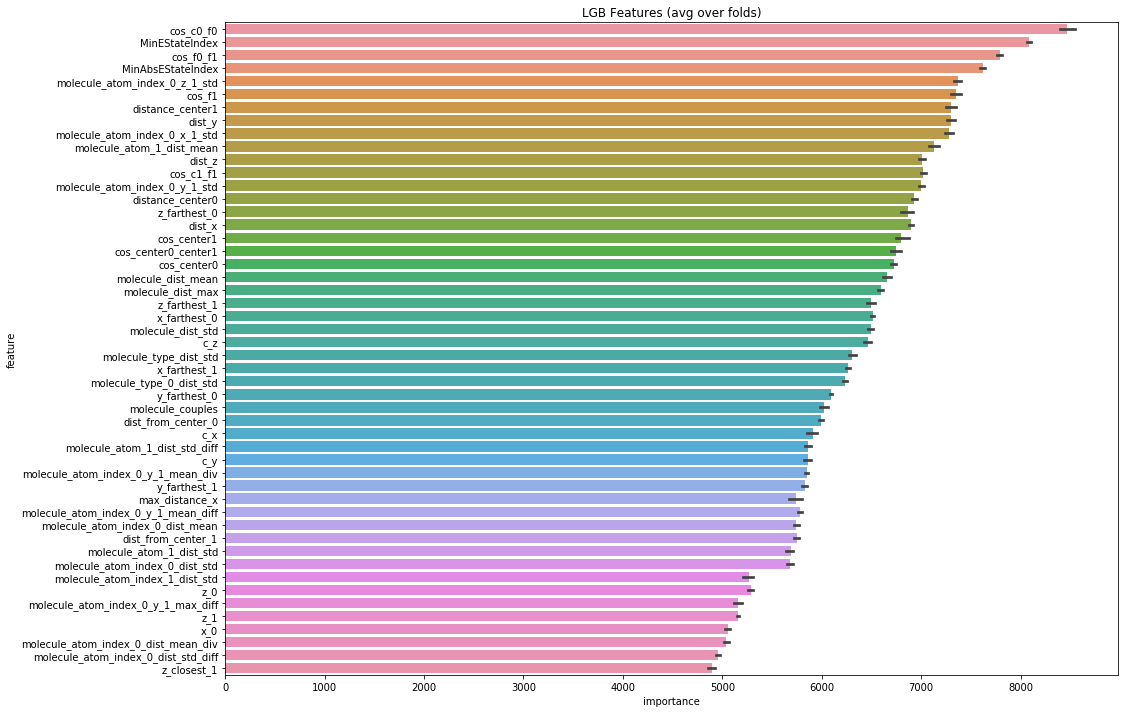

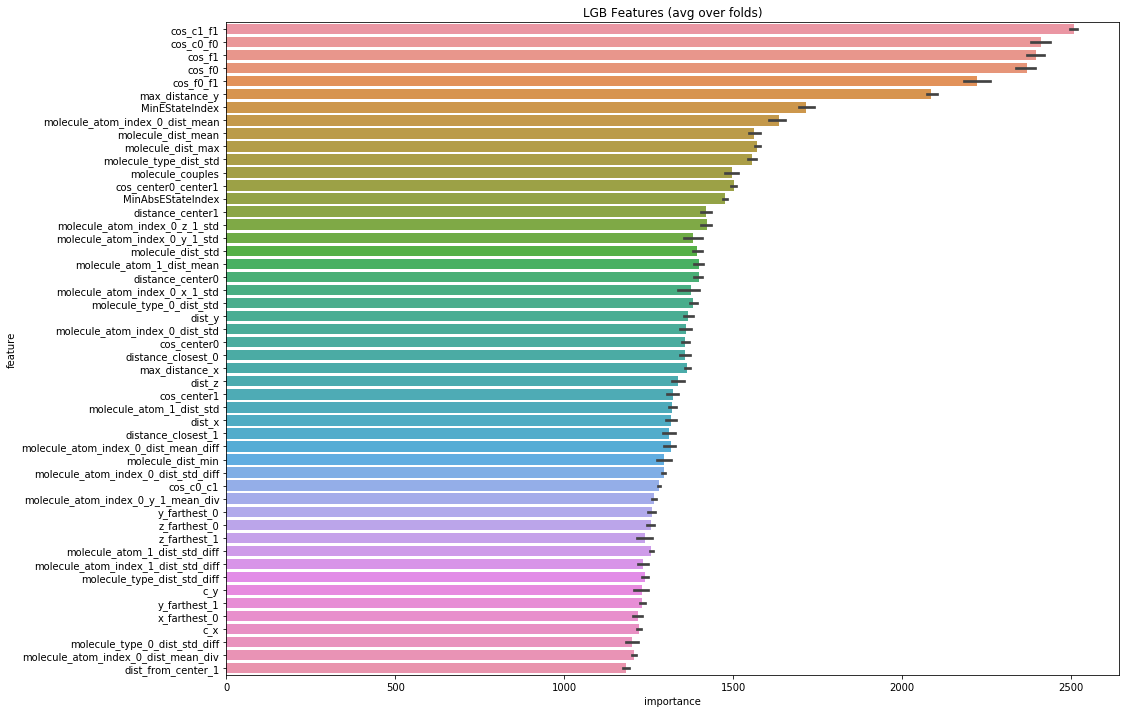

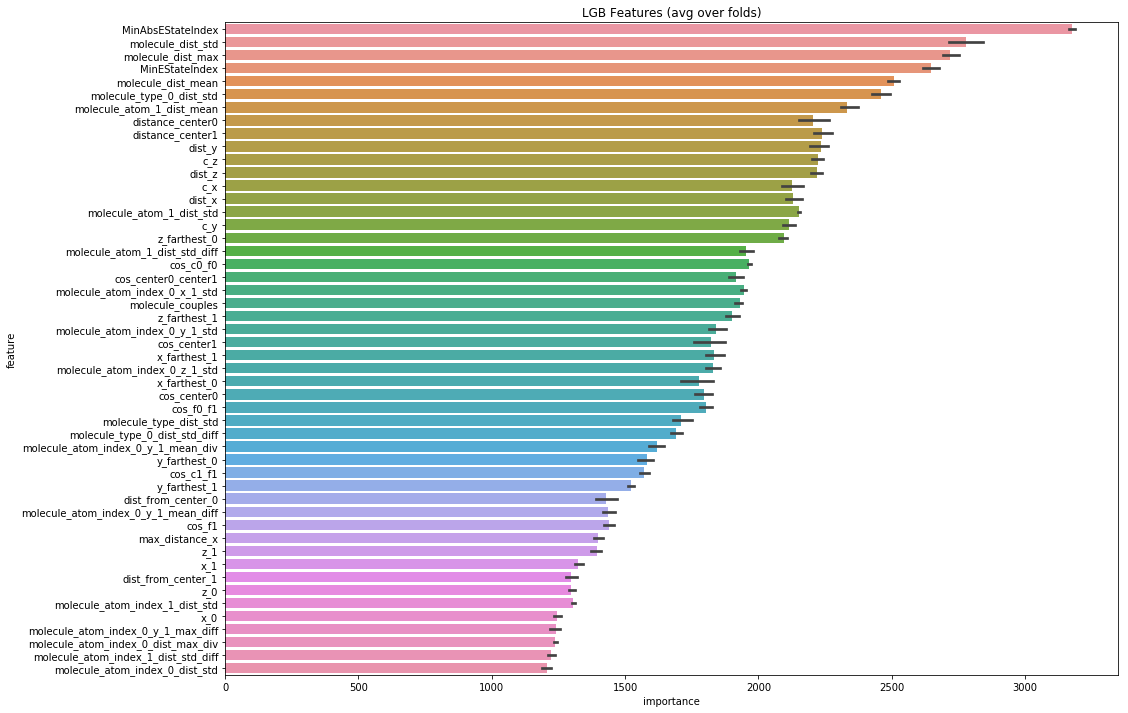

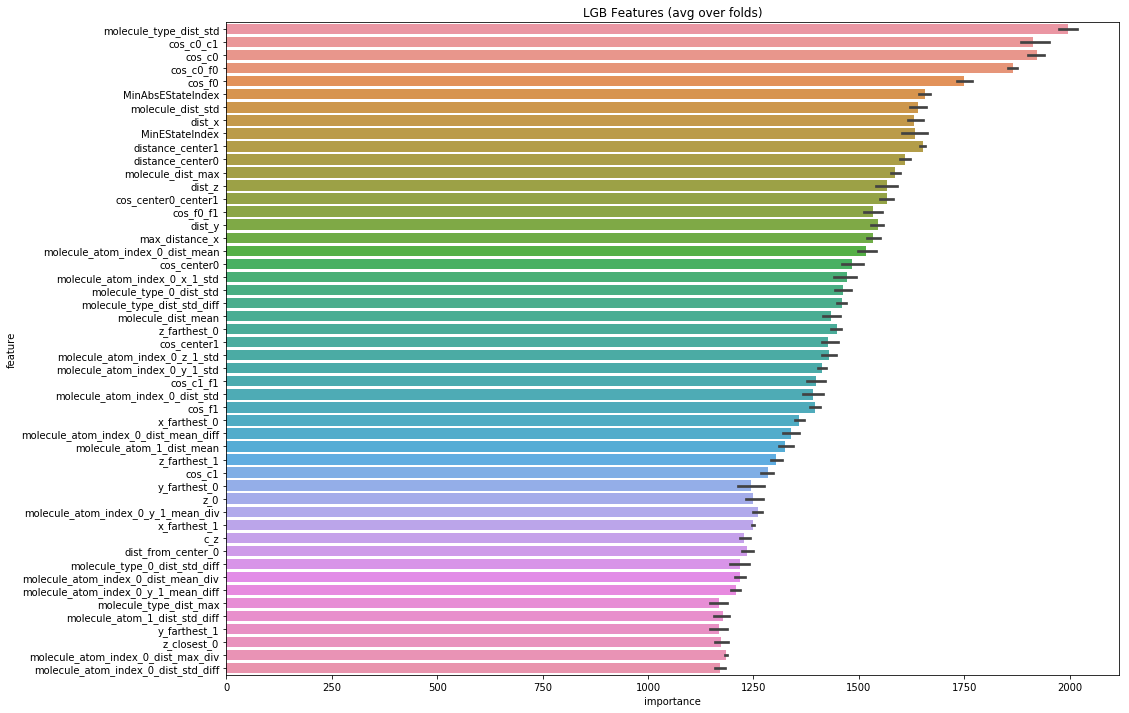

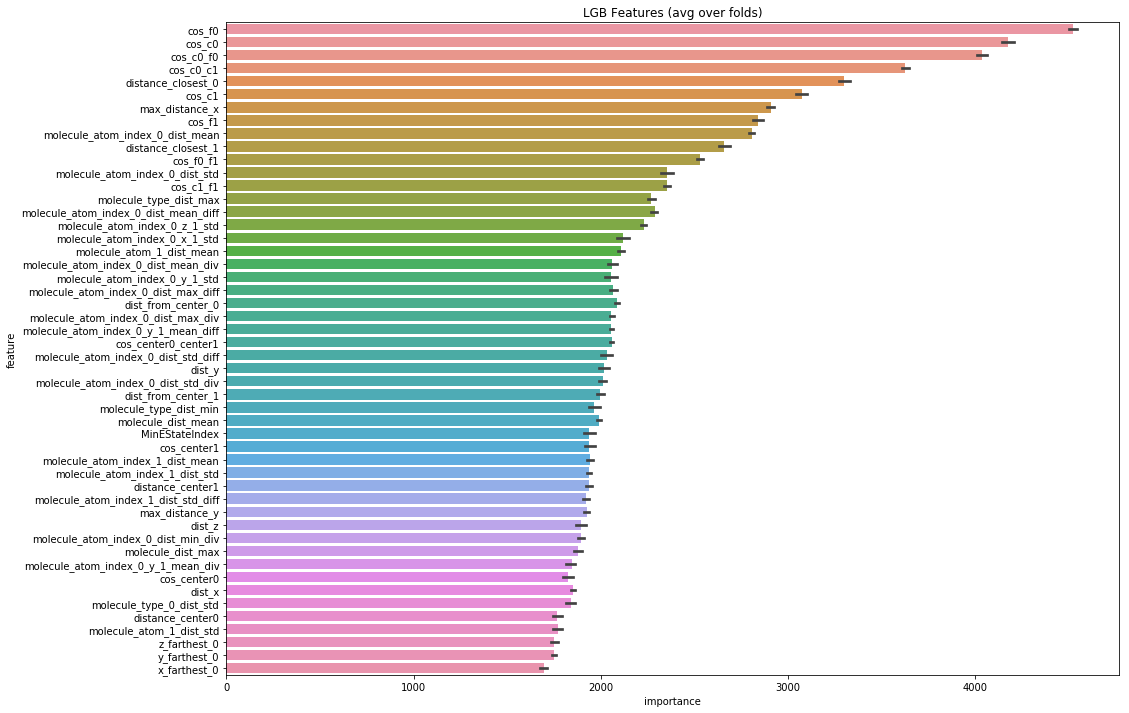

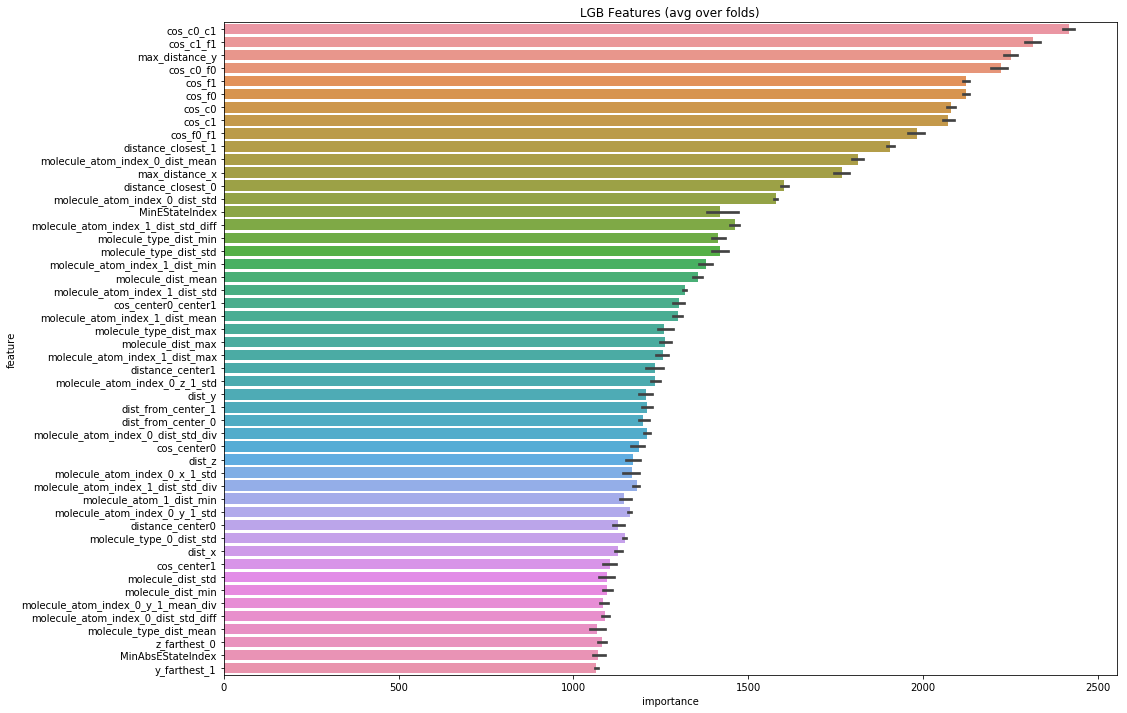

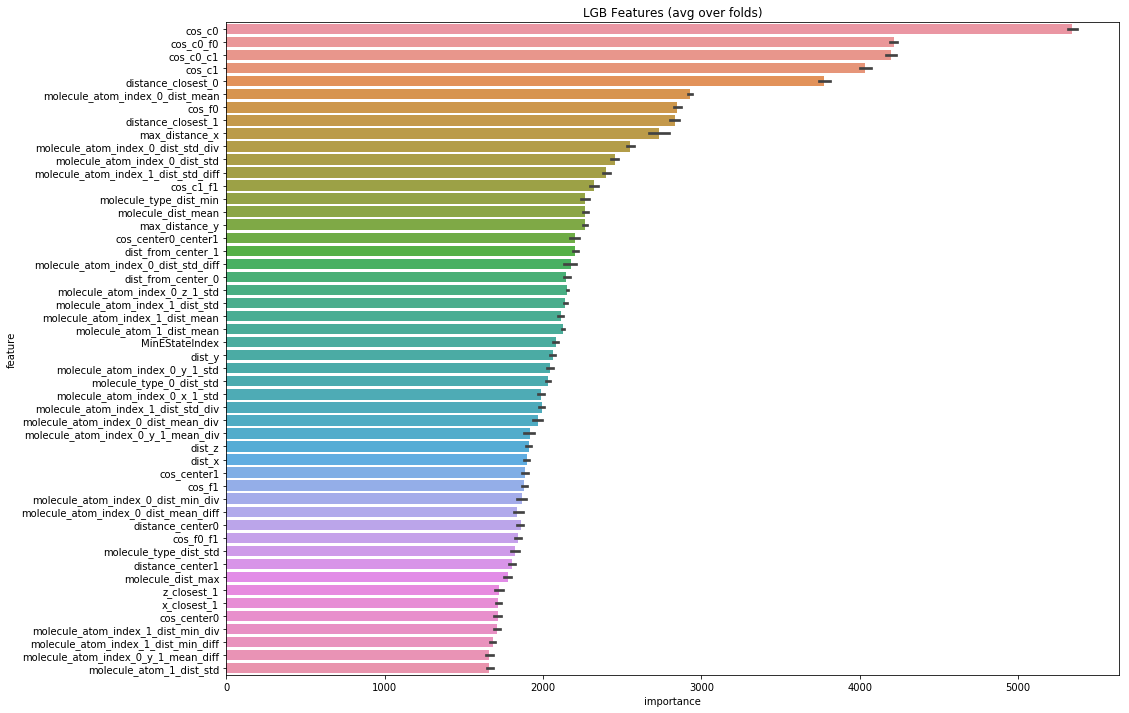

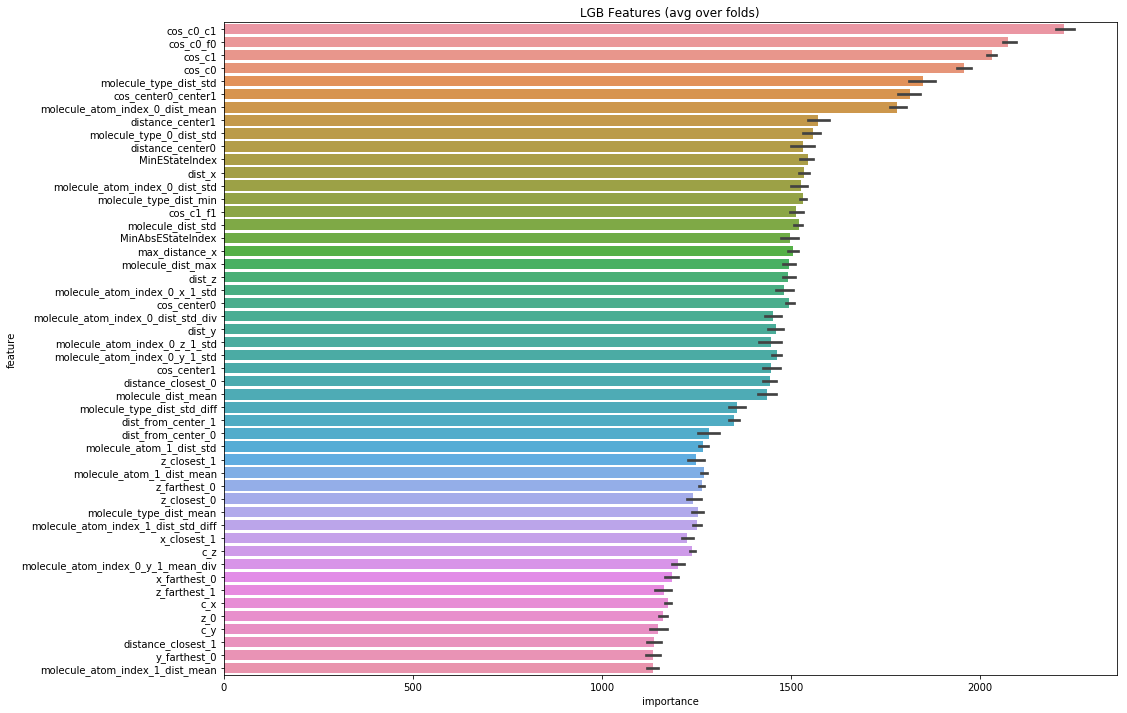

In [44]:
#Run
CV_score = 0

for t in train_merged['type'].unique():
    type_ = lbl.inverse_transform([t])[0]
    print(f'\nTraining of type {t}: {type_}.')
    index_type = (train_merged['type'] == t)
    index_type_test = (test_merged['type'] == t)
    
    X_t = x_train.loc[index_type].copy()
    X_test_t = x_test.loc[index_type_test].copy()
    y_t = y_train[index_type]
    
    #print(f'Generating features...')
    #start_time = time.time()
    
    ## Generating features from the public kernels, just by type
    ## no memory reduction is needed
    #X_t = get_features(X_t, structures.copy())
    #X_t = X_t[good_columns].fillna(0.0)
    
    #X_test_t = get_features(X_test_t, structures.copy())
    #X_test_t = X_test_t[good_columns].fillna(0.0)
    
    ## load Giba's features just for type t by getting rows to be excluded when initiating read_csv
    #rows_to_exclude = np.where(index_type==False)[0]+1 # retain the header row
    #rows_to_exclude_test = np.where(index_type_test==False)[0]+1
    #train_giba_t = pd.read_csv('../input/giba-molecular-features/train_giba.csv/train_giba.csv',
    #                    header=0, skiprows=rows_to_exclude, usecols=giba_columns)
    #test_giba_t = pd.read_csv('../input/giba-molecular-features/test_giba.csv/test_giba.csv',
    #                   header=0, skiprows=rows_to_exclude_test, usecols=giba_columns)
    
    #X_t = pd.concat((X_t, train_giba_t), axis=1)

    #X_test_t = pd.concat((X_test_t,test_giba_t), axis=1) 
    
    #del train_giba_t, test_giba_t
    #gc.collect()
    
    #print(f'Done in {(time.time() - start_time):.2f} seconds for {X_t.shape[1]} features.')
    ## feature generation done
    
    
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=folds, 
                                              model_type='lgb', 
                                              eval_metric='mae', 
                                              plot_feature_importance=True,
                                              verbose=500, early_stopping_rounds=200, 
                                              n_estimators=n_estimators[t])
    del X_t, X_test_t
    gc.collect()
    
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
    ## manually computing the cv score
    CV_score += np.log(np.array(result_dict_lgb['scores']).mean())/8 # total 8 types

In [45]:
#sample_submission = pd.read_csv('sample_submission.csv')

#benchmark = sample_submission.copy()
#benchmark['scalar_coupling_constant'] = result_dict_lgb_oof['prediction']
#benchmark.to_csv('LGBM_submission.csv',index=False)

sub['scalar_coupling_constant'] = X_short_test['prediction']
#today = str(datetime.date.today())
sub.to_csv('LightGBM_190720.csv', index=False)

In [46]:
#benchmark.head()

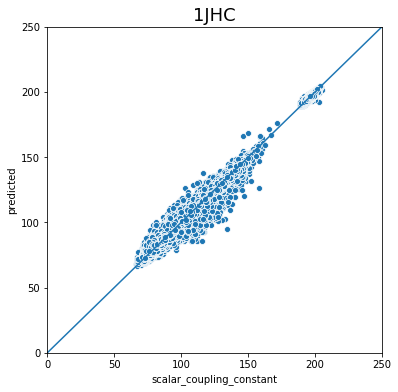

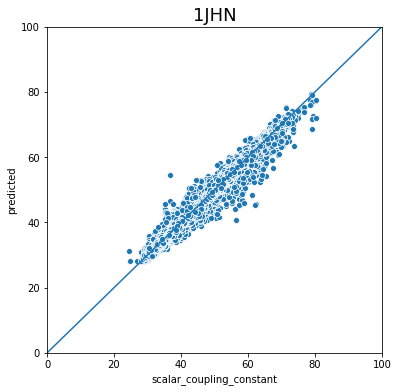

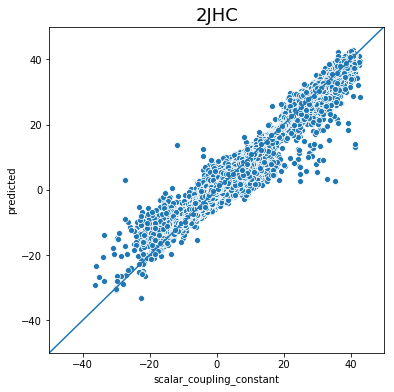

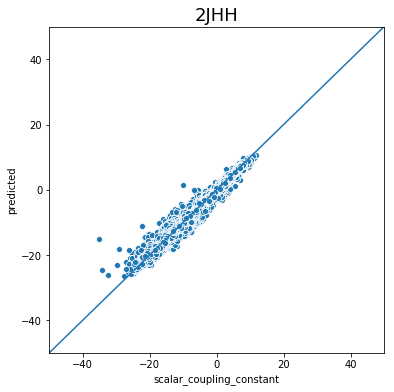

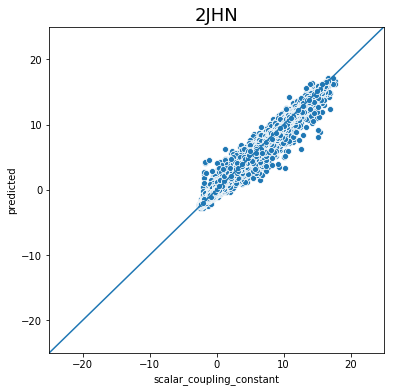

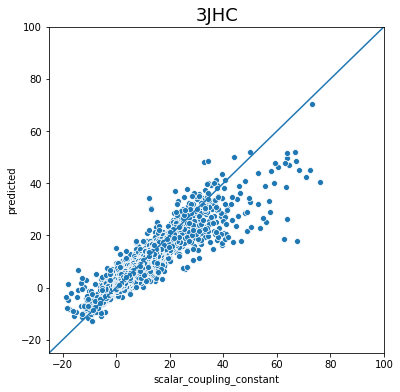

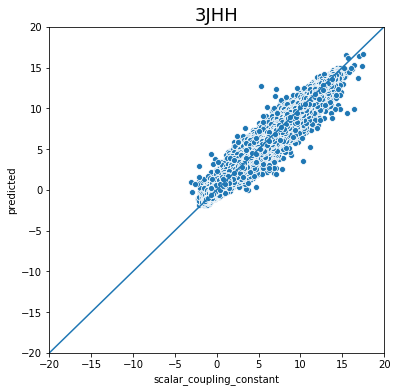

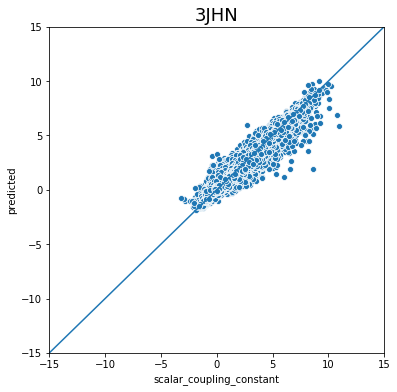

In [47]:
plot_data = pd.DataFrame(train_merged['scalar_coupling_constant'])
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = lbl.inverse_transform(X_short['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)